In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [14]:
#büyük veriyi daha kolay ele alabilmek için tf.data kullanıcaz
#bu veriyi batchlere bölüp daha kolay preprocess etmemizi sağlayacak

IMAGE_SIZE = 256
BATCH_SIZE = 32  
CHANNELS = 3
EPOCHS = 50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PotatoPlants",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # 2152 / 32(batch size)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

#take(1) yöntemi, dataset içerisinden sadece bir parti (batch) veri alır
#image_batch değişkeni, bu partideki görüntüleri (resim verilerini) temsil eder.
#label_batch değişkeni, bu partideki görüntülere ait etiketleri (label'ları) temsil eder yani mesela healthy, late , early gibi

(32, 256, 256, 3)
[0 1 0 1 1 1 0 2 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1]


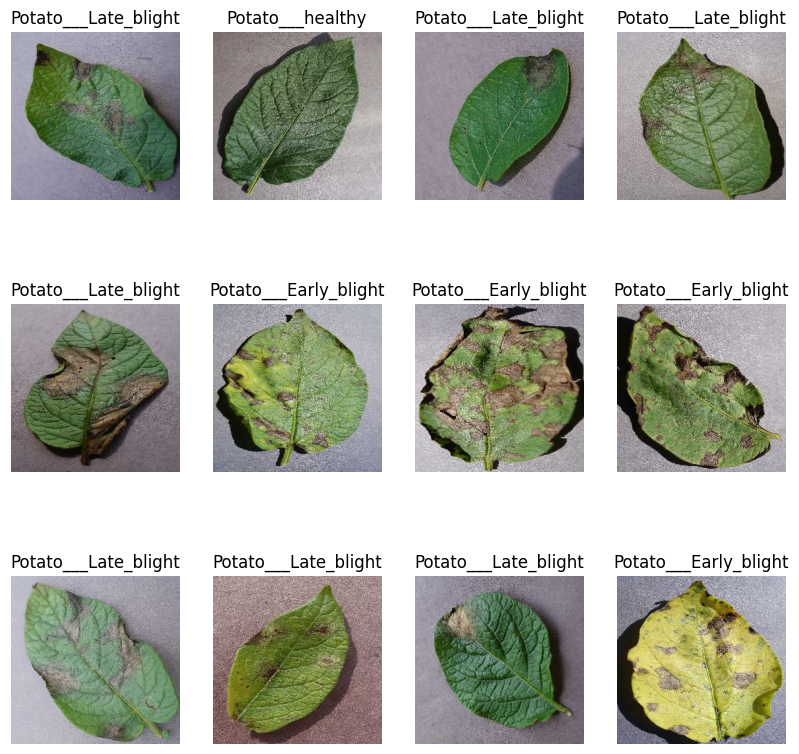

In [13]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #uint8 rgb değerlerini almasını sağlıyo
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [22]:
# 0.8 training, 0.1 validation, 0.1 test olacak. her epoch sonunda 
# validation uygulıycaz. 50 epoch bitip de elimizde final model olunca 
# test edicez

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds = dataset.take(54) #first 54

In [24]:
test_ds = dataset.skip(54) #remaining
len(test_ds)

14

In [25]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [27]:
val_ds = test_ds.take(6)

In [28]:
test_ds= test_ds.skip(6) #8

In [29]:
##bunun hepsini fonk ile yaparsak :

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

54

In [32]:
len(val_ds)

6

In [33]:
len(test_ds)

8

In [34]:
#cachede olması tekradan kullanım gerekirse diye memoryde tutulmasını sağlayacak ve performansı arttıracak

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [35]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
#data augmentation >> orijinal imagei alıp horizontal flip, contrast, rotation, 
# zoom uygulayıp daha fazla image elde ediyosun ve bu modelin daha iyi öğrenmesini sağlıyor

data_auggmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### model building

In [40]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_auggmentation,
    layers.Conv2D(32,(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

In [41]:
model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [44]:
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [45]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 69s 1s/step - loss: 0.9012 - accuracy: 0.4682 - val_loss: 0.8627 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 63s 1s/step - loss: 0.7046 - accuracy: 0.6632 - val_loss: 0.6224 - val_accuracy: 0.6875
Epoch 3/50
54/54 [==============================] - 59s 1s/step - loss: 0.5423 - accuracy: 0.7708 - val_loss: 0.6079 - val_accuracy: 0.7448
Epoch 4/50
54/54 [==============================] - 60s 1s/step - loss: 0.4276 - accuracy: 0.8194 - val_loss: 0.3376 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 60s 1s/step - loss: 0.3201 - accuracy: 0.8565 - val_loss: 0.2461 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 59s 1s/step - loss: 0.2688 - accuracy: 0.8970 - val_loss: 0.1272 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 60s 1s/step - loss: 0.2339 - accuracy: 0.9068 - val_loss: 0.2060 - val_accuracy: 0.9219
Epoch 8/50
54/54 [==

In [47]:
scores =model.evaluate(test_ds)

8/8 [==============================] - 2s 206ms/step - loss: 0.1076 - accuracy: 0.9688


In [48]:
scores

[0.1075904592871666, 0.96875]

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
history.history["accuracy"]

[0.46817129850387573,
 0.6631944179534912,
 0.7708333134651184,
 0.8194444179534912,
 0.8564814925193787,
 0.8969907164573669,
 0.9068287014961243,
 0.9195601940155029,
 0.9450231194496155,
 0.9415509104728699,
 0.9288194179534912,
 0.9589120149612427,
 0.9658564925193787,
 0.9716435074806213,
 0.9820601940155029,
 0.9780092835426331,
 0.9751157164573669,
 0.9809027910232544,
 0.9537037014961243,
 0.9780092835426331,
 0.9722222089767456,
 0.9797453880310059,
 0.9780092835426331,
 0.9797453880310059,
 0.9837962985038757,
 0.9890046119689941,
 0.9936342835426331,
 0.9884259104728699,
 0.9878472089767456,
 0.9762731194496155,
 0.9820601940155029,
 0.9918981194496155,
 0.9809027910232544,
 0.9918981194496155,
 0.9855324029922485,
 0.9866898059844971,
 0.9878472089767456,
 0.9895833134651184,
 0.9751157164573669,
 0.9884259104728699,
 0.9878472089767456,
 0.9965277910232544,
 0.984375,
 0.9872685074806213,
 0.9814814925193787,
 0.9837962985038757,
 0.9901620149612427,
 0.9890046119689941,
 

In [53]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss=val_acc = history.history["val_loss"]

Text(0.5, 1.0, 'training and validation loss')

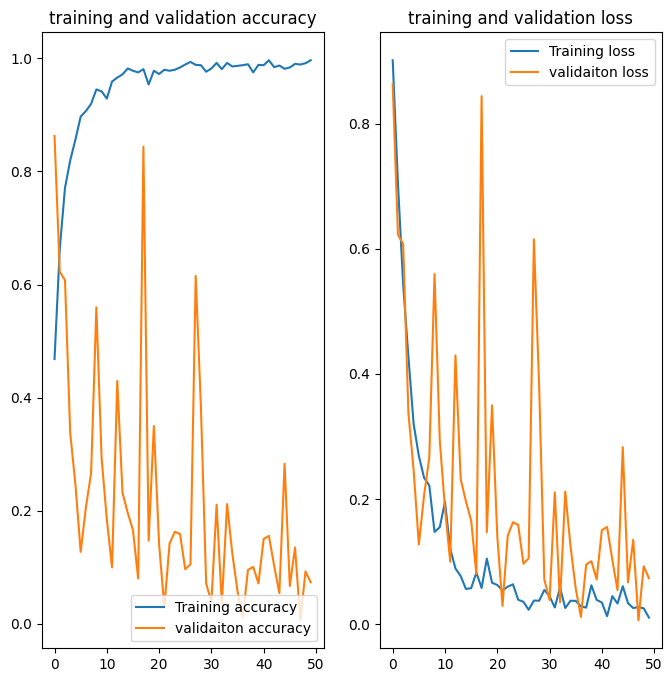

In [57]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training accuracy")
plt.plot(range(EPOCHS), val_acc, label="validaiton accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="validaiton loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 239ms/step
predicted label: Potato___Late_blight


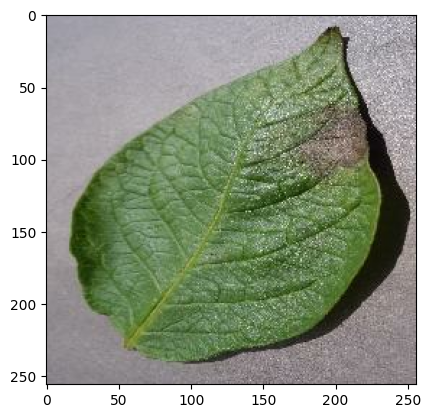

In [59]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction= model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])] )

In [60]:
def predict(model,img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array,0) #create a batch

    predictions= model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 34ms/step


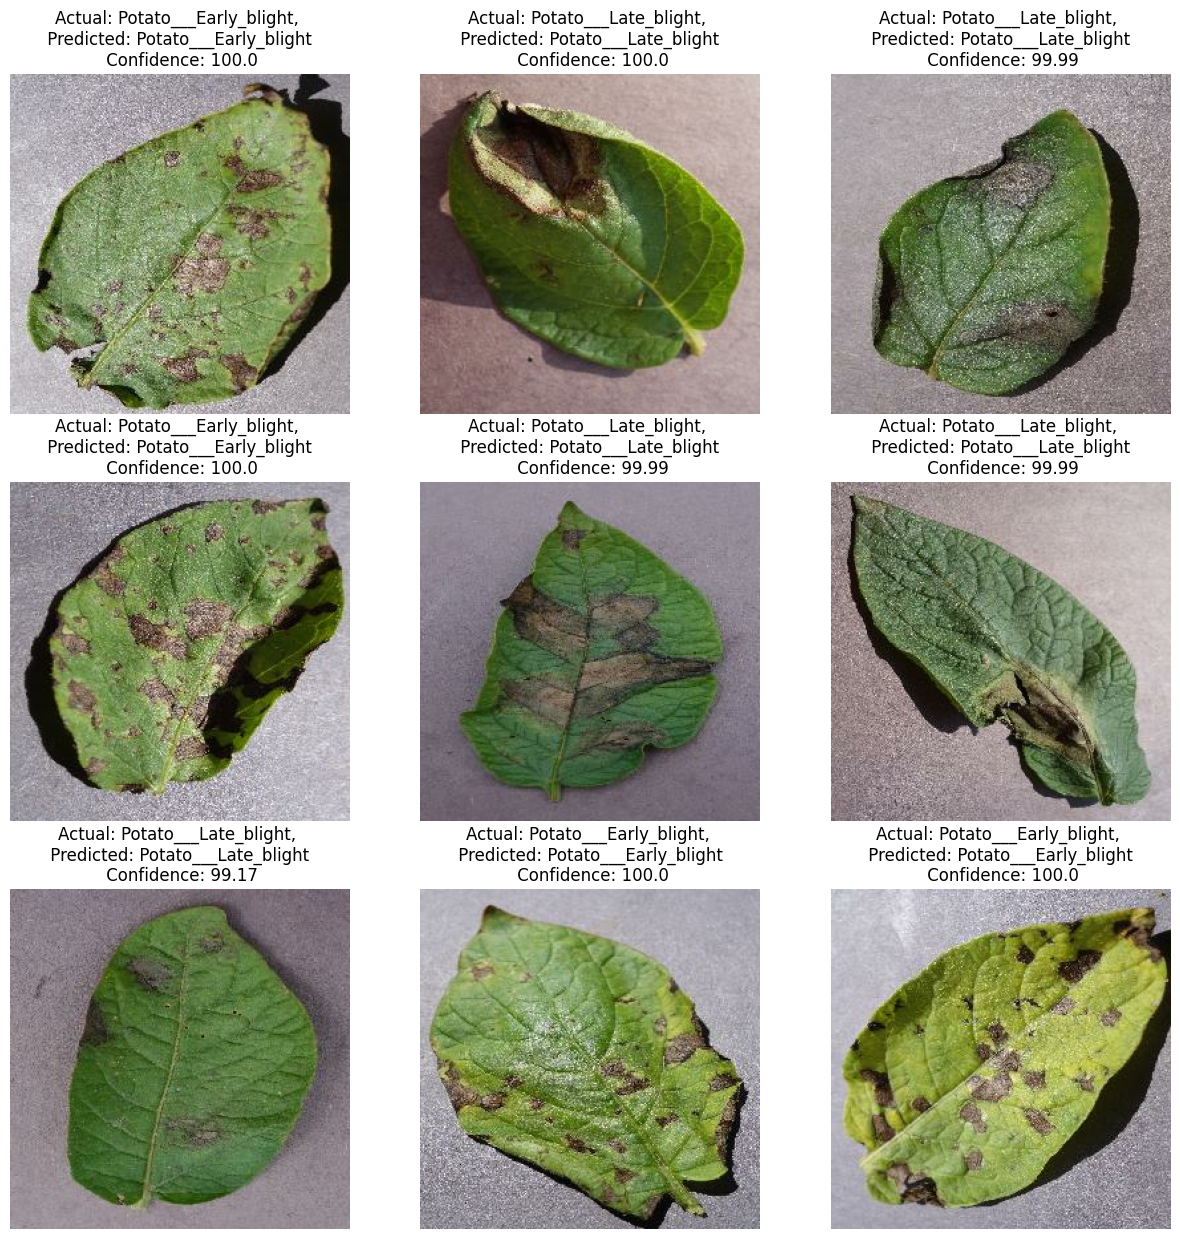

In [64]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}")

        plt.axis("off")

In [65]:
import os
model_version = max([int (i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

#bu sayede yeni bir model versiyonu yapıldığında otomatik kaydedecek

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
